## Abstract

This project investigates the effectiveness of a simple z-score-based pairs trading strategy on four historically correlated stock pairs: KO/PEP, MS/GS, NFLX/DIS, and V/MA. Using a 20-day rolling mean and standard deviation of the price spread, we generate entry signals at |z| > 2 and evaluate performance over a full backtest and a 2024 out-of-sample test. While the strategy achieved moderate success in-sample with a total log return of 1.28, the out-of-sample results were surprisingly strong (log return of 0.46 in 2024), particularly for NFLX/DIS and MS/GS, suggesting that the strategy may generalize under certain conditions.

## Introduction

Pairs trading is a classic market-neutral strategy that attempts to exploit mean-reverting behavior in the relative prices of two historically correlated assets. When the spread between two such assets diverges significantly from its historical mean, a trader takes offsetting positions in the expectation that the spread will revert. This project evaluates a simple implementation of this strategy on four equity pairs across diverse sectors. Our goal is to assess both in-sample profitability and out-of-sample robustness of the strategy.

## Setup

We use daily adjusted close prices from Yahoo Finance for the period 2015 to early 2025. The selected pairs are:
- KO (Coca-Cola) & PEP (Pepsi)
- MS (Morgan Stanley) & GS (Goldman Sachs)
- NFLX (Netflix) & DIS (Disney)
- V (Visa) & MA (Mastercard)
Data was aligned, cleaned, and stored in a tidy Pandas DataFrame format.

In [110]:
import yfinance as yf
import pandas as pd

# These lines import the Numpy and Datascience modules.
import numpy as np
from datascience import *

# These lines do some fancy plotting magic.
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import warnings
warnings.simplefilter('ignore', FutureWarning)

In [64]:
tickers = ['KO', 'PEP', 'MS', 'GS', 'NFLX', 'DIS', 'V', 'MA']
pairs = [['KO', 'PEP'], ['MS', 'GS'], ['NFLX', 'DIS'], ['V', 'MA']]
data = yf.download(tickers, start='2010-01-01', end='2024-01-01', group_by='ticker')

[*********************100%***********************]  8 of 8 completed


In [22]:
data


Ticker             MS                                                   NFLX  \
Price            Open       High        Low      Close    Volume        Open   
Date                                                                           
2010-01-04  21.998397  22.908428  21.948237  22.148874  20371000    7.931429   
2010-01-05  22.220532  23.023080  22.163207  22.958590  22523400    7.652857   
2010-01-06  22.908421  23.352689  22.779441  23.252371  17028500    7.361429   
2010-01-07  23.259540  23.839955  23.123395  23.589157  18693000    7.731429   
2010-01-08  23.359867  23.517511  22.915600  23.109072  15993400    7.498571   
...               ...        ...        ...        ...       ...         ...   
2023-12-22  88.333818  89.056465  87.696752  87.867905   5800800  494.000000   
2023-12-26  88.058073  88.447917  87.829871  88.276764   2726200  489.390015   
2023-12-27  88.134149  89.084997  87.858402  89.056473   4073200  491.239990   
2023-12-28  88.723663  89.332206  88.657104  89.037445   4089500  492.000000   
2023-12-29  88.894820  89.161056  88.485955  88.666618   4772100  490.369995   

Ticker                                                    ...          MA  \
Price             High         Low       Close    Volume  ...        Open   
Date                                                      ...               
2010-01-04    7.961429    7.565714    7.640000  17239600  ...   23.787186   
2010-01-05    7.657143    7.258571    7.358571  23753100  ...   23.773358   
2010-01-06    7.672857    7.197143    7.617143  23290400  ...   23.639681   
2010-01-07    7.757143    7.462857    7.485714   9955400  ...   23.377681   
2010-01-08    7.742857    7.465714    7.614286   8180900  ...   23.278967   
...                ...         ...         ...       ...  ...         ...   
2023-12-22  496.019989  485.450012  486.760010   2701100  ...  421.017909   
2023-12-26  491.480011  486.380005  491.190002   2034500  ...  421.265749   
2023-12-27  494.019989  489.250000  491.790009   2561300  ...  419.283251   
2023-12-28  492.890015  489.070007  490.510010   1710500  ...  420.046515   
2023-12-29  492.230011  481.940002  486.880005   2739500  ...  422.930910   

Ticker                                                           KO  \
Price             High         Low       Close    Volume       Open   
Date                                                                  
2010-01-04   23.806549   23.610159   23.681154   9321000  17.855793   
2010-01-05   23.784422   23.331711   23.611082  12906000  17.758952   
2010-01-06   23.639681   23.294643   23.576946  10785000  17.602764   
2010-01-07   23.438570   23.154420   23.422886  11273000  17.596517   
2010-01-08   23.517911   23.220846   23.431190   8635000  17.324753   
...                ...         ...         ...       ...        ...   
2023-12-22  423.416659  419.243629  420.373627   1759000  55.984392   
2023-12-26  421.979424  419.233774  419.947449   1258200  55.926595   
2023-12-27  421.275600  419.243594  420.631287   1324100  56.485284   
2023-12-28  424.596181  419.957309  422.574127   1505000  56.494916   
2023-12-29  424.586250  420.542082  422.762421   1706100  56.581608   

Ticker                                                 
Price            High        Low      Close    Volume  
Date                                                   
2010-01-04  17.874537  17.774574  17.818308  13870400  
2010-01-05  17.802686  17.537160  17.602760  23172400  
2010-01-06  17.630879  17.487183  17.596518  19264600  
2010-01-07  17.609011  17.415334  17.552782  13234600  
2010-01-08  17.380982  17.102961  17.227915  28712400  
...               ...        ...        ...       ...  
2023-12-22  56.311899  55.888068  56.177044   9028500  
2023-12-26  56.552708  55.926595  56.408222   6422500  
2023-12-27  56.610508  56.254105  56.552711   8560100  
2023-12-28  56.706830  56.379323  56.591240   8400100  
2023-12-29  56.812788  56.475650  56.764626   9241600  

[3522 rows x 40 colu

In [27]:
close = pd.DataFrame({
    ticker: data[ticker]['Close']
    for ticker in tickers
})

In [28]:
close

,KO,PEP,MS,GS,NFLX,DIS,V,MA
Date,,,,,,,,
2010-01-04,17.818308,39.133671,22.148874,132.649887,7.640000,27.593046,19.719198,23.681154
2010-01-05,17.602760,39.606541,22.958590,134.995163,7.358571,27.524216,19.493238,23.611082
2010-01-06,17.596518,39.210358,23.252371,133.554276,7.617143,27.377943,19.231483,23.576946
2010-01-07,17.552782,38.961143,23.589157,136.167755,7.485714,27.386549,19.410465,23.422886
2010-01-08,17.227915,38.833340,23.109072,133.592651,7.614286,27.429569,19.464142,23.431190
...,...,...,...,...,...,...,...,...
2023-12-22,56.177044,161.053055,87.867905,369.813385,486.760010,90.202316,255.614273,420.373627
2023-12-26,56.408222,162.186401,88.276764,370.746063,491.190002,90.132942,256.336334,419.947449
2023-12-27,56.552711,162.705063,89.056473,373.534363,491.790009,89.568062,256.108795,420.631287


We will work with the closing prices because that is safer and sufficient.

## Methodology

For each pair, we compute the spread as the difference between the two assets' prices $(B − A)$. We then calculate a 20-day rolling mean and standard deviation of the spread, and use this to compute a **z-score**:
`python: z = (spread - rolling_mean) / rolling_std`
Trading signals are generated as follows:
Enter Long Spread (Short B, Long A) when $z < -2$
Enter Short Spread (Long B, Short A) when $z > +2$
Positions are entered on the next day after the signal is triggered (to avoid lookahead bias). We calculate daily log returns of each asset, and compute strategy returns as:
`strategy_return = position * (return_A - return_B)`
We aggregate these returns cumulatively to compute total **PnL**, and evaluate performance using Sharpe ratios (annualized).
For robustness, we reserve 2024 as an out-of-sample test period. The same rules and thresholds are applied to this year without re-tuning.

**Calculate Spread and Z-Score**

Starting with **Coca Cola** and **Pepsi**, we can look at the Static hedge ratio, and create a rolling z-score.

In [48]:
KO_PEP = close[pairs[0]].dropna()
KO_PEP['spread'] = KO_PEP['PEP'] - KO_PEP['KO']

rolling_window = 20
mean = KO_PEP['spread'].rolling(rolling_window).mean()
std = KO_PEP['spread'].rolling(rolling_window).std()
KO_PEP['zscore'] = (KO_PEP['spread'] - mean) / std

KO_PEP.tail()

,KO,PEP,spread,zscore
Date,,,,
2023-12-22,56.177044,161.053055,104.876011,0.154727
2023-12-26,56.408222,162.186401,105.778179,0.981746
2023-12-27,56.552711,162.705063,106.152351,1.238171
2023-12-28,56.591240,162.695465,106.104225,1.079253
2023-12-29,56.764626,163.127686,106.363060,1.226109


Since we are dealing with **z-scores**, we would expect them to be normally distributed. Let's check:

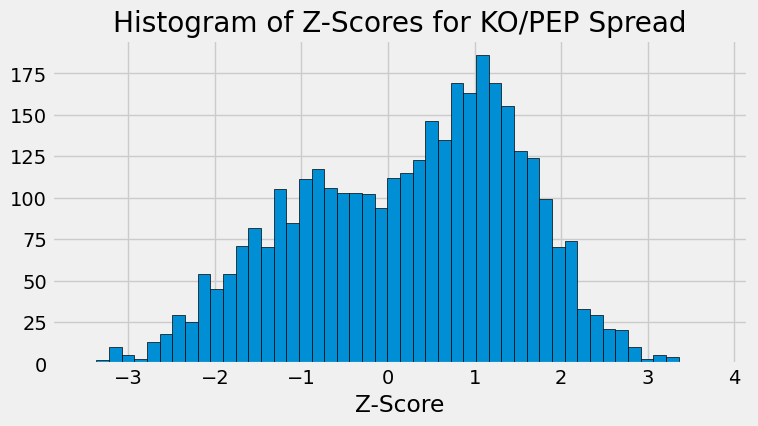

In [49]:
KO_PEP['zscore'].dropna().hist(bins=50,edgecolor='black',figsize=(8,4))

plt.title('Histogram of Z-Scores for KO/PEP Spread')
plt.xlabel('Z-Score')
plt.grid(True)
plt.show()

This is not the case, and the distribution is skewed right. These results suggest that the spread between Coke and Pepsi is not consistently centered around its recent mean. This implies the pair may drift or trend, reducing the effectiveness of a naive mean-reversion strategy without additional adjustments.

We can make sense of this distribution by comparing the stocks over time.

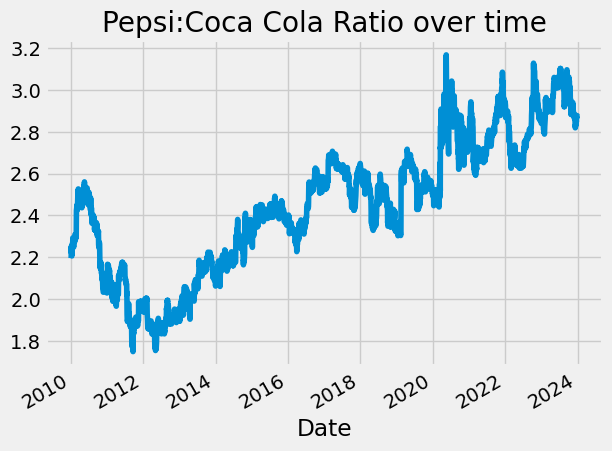

In [59]:
KO_PEP['PEP/KO Ratio'] = KO_PEP['PEP'] / KO_PEP['KO']
KO_PEP['PEP/KO Ratio'].dropna().plot()
plt.title('Pepsi:Coca Cola Ratio over time')
plt.show()

As you can see, Pepsi shares have increased relative to Coca Cola Shares over the past 10 years. It thus makes sense why Pepsi has had more "good days" than "bad," as indicated by the right-skewed distribution in the histogram of z-scores.

Let's look at the other three pairs of data.

**Morgan Stanley and Goldman Sachs, Netflix and Disney, Visa and Mastercard:**

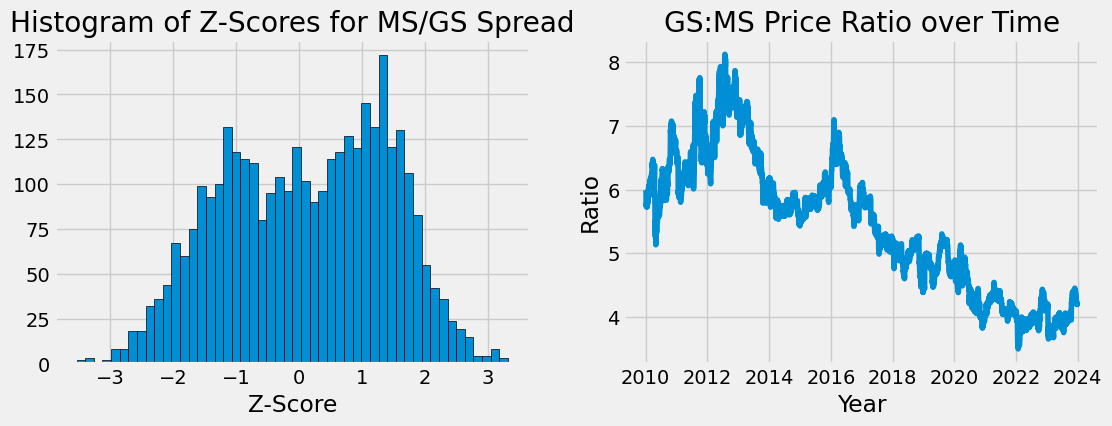

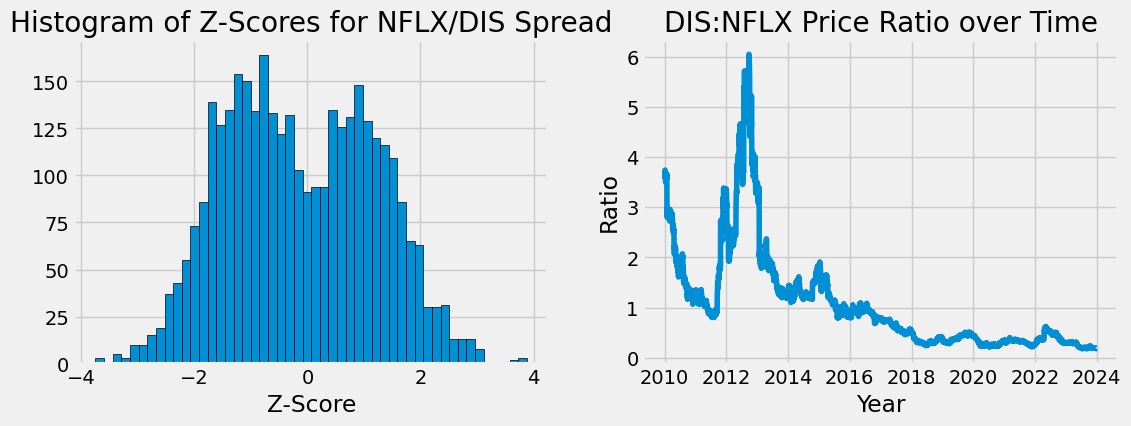

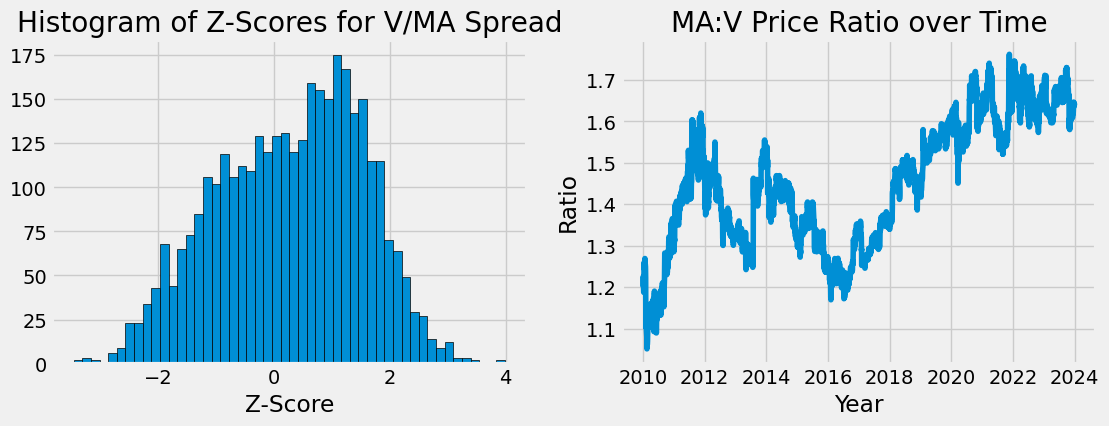

In [63]:
for pair in pairs[1:]:
    pair_data = close[pair].dropna()
    pair_data['spread'] = pair_data[pair[1]] - pair_data[pair[0]]

    rolling_window = 20
    mean = pair_data['spread'].rolling(rolling_window).mean()
    std = pair_data['spread'].rolling(rolling_window).std()
    pair_data['zscore'] = (pair_data['spread'] - mean) / std

    pair_data['Ratio'] = pair_data[pair[1]] / pair_data[pair[0]]

    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    axes[0].hist(pair_data['zscore'].dropna(), bins = 50, edgecolor = 'black')
    axes[0].set_title(f'Histogram of Z-Scores for {pair[0]}/{pair[1]} Spread')
    axes[0].set_xlabel('Z-Score')
    axes[0].grid(True)

    axes[1].plot(pair_data['Ratio'].index, pair_data['Ratio'])
    axes[1].set_title(f'{pair[1]}:{pair[0]} Price Ratio over Time')
    axes[1].set_xlabel('Year')
    axes[1].set_ylabel('Ratio')
    axes[1].grid(True)
    
    plt.show()

ChatGPT says, "These plots help assess the mean-reverting potential of each pair. While V/MA appears stable and mean-reverting, MS/GS and NFLX/DIS show signs of divergence or structural change, which may require either dynamic modeling or rejection as a tradeable pair."

If we make safer trades, such as when the |z-score|≥2 as opposed to 1, we may still profit. Let us backtest.

In [100]:
total_PnL = 0
pair_results_PnL = {}
pair_sharpes = {}

for pair in pairs:
    a, b = pair
    pair_data = close[[a, b]].dropna()

    pair_data['spread'] = pair_data[b] - pair_data[a]

    rolling_window = 20
    mean = pair_data['spread'].rolling(rolling_window).mean()
    std = pair_data['spread'].rolling(rolling_window).std()
    pair_data['zscore'] = (pair_data['spread'] - mean) / std

    pair_data['position'] = 0
    pair_data.loc[pair_data['zscore'] > 2, 'position'] = 1
    pair_data.loc[pair_data['zscore'] < -2, 'position'] = -1

    pair_data['position'] = pair_data['position'].shift()

    pair_data['ret_a'] = np.log(pair_data[a]).diff()
    pair_data['ret_b'] = np.log(pair_data[b]).diff()

    pair_data['strategy_return'] = pair_data['position'] * (pair_data['ret_a'] - pair_data['ret_b'])

    pair_data['cumulative_return'] = pair_data['strategy_return'].cumsum()

    daily_returns = pair_data['strategy_return'].dropna()
    sharpe = daily_returns.mean() / daily_returns.std() * np.sqrt(252)
    pair_sharpes[f'{a} & {b}']  = sharpe

    total_PnL += pair_data['strategy_return'].sum()
    pair_results_PnL[f'{a} & {b}'] = pair_data['strategy_return'].sum()

print(f"Total Strategy PnL (log): {total_PnL}")
print(f"Breakdown: {pair_results_PnL}")
print(f"Sharpes: {pair_sharpes}")

Total Strategy PnL (log): 1.2758376842242494
Breakdown: {'KO & PEP': 0.37904289425861881, 'MS & GS': 0.078248747567243093, 'NFLX & DIS': 0.14571890963223444, 'V & MA': 0.67282713276615302}
Sharpes: {'KO & PEP': 0.50545517384282623, 'MS & GS': 0.066013528010873401, 'NFLX & DIS': 0.061059782656298564, 'V & MA': 0.88991301907602161}


$e^{1.276} \approx 160 \%$ return! However, our Sharpe ratios are not to par.

Since we chose our z-scores based on the plots we made for the years 2010 to 2014. It makes sense to test the strategy (even though it is very risky) on the most recent data. We will test the data on 2024.

In [105]:
test_data = yf.download(tickers, start='2024-01-01', end='2025-01-01', group_by='ticker')
test_close = pd.DataFrame({
    ticker: test_data[ticker]['Close']
    for ticker in tickers
})

total_PnL_test = 0
pair_results_PnL_test = {}
pair_sharpes_test = {}

for pair in pairs:
    a, b = pair
    test_pair_data = test_close[[a, b]].dropna()

    test_pair_data['spread'] = test_pair_data[b] - test_pair_data[a]

    rolling_window = 20
    mean = test_pair_data['spread'].rolling(rolling_window).mean()
    std = test_pair_data['spread'].rolling(rolling_window).std()
    test_pair_data['zscore'] = (test_pair_data['spread'] - mean) / std

    test_pair_data['position'] = 0
    test_pair_data.loc[test_pair_data['zscore'] > 2, 'position'] = 1
    test_pair_data.loc[test_pair_data['zscore'] < -2, 'position'] = -1

    test_pair_data['position'] = test_pair_data['position'].shift()

    test_pair_data['ret_a'] = np.log(test_pair_data[a]).diff()
    test_pair_data['ret_b'] = np.log(test_pair_data[b]).diff()

    test_pair_data['strategy_return'] = test_pair_data['position'] * (test_pair_data['ret_a'] - test_pair_data['ret_b'])

    test_pair_data['cumulative_return'] = test_pair_data['strategy_return'].cumsum()

    daily_returns_test = test_pair_data['strategy_return'].dropna()
    sharpe = daily_returns_test.mean() / daily_returns_test.std() * np.sqrt(252)
    pair_sharpes_test[f'{a} & {b}']  = sharpe
    total_PnL_test += test_pair_data['strategy_return'].sum()
    pair_results_PnL_test[f'{a} & {b}'] = test_pair_data['strategy_return'].sum()

print(f"Total Strategy PnL (log): {total_PnL_test}")
print(f"Breakdown: {pair_results_PnL_test}")
print(f"Sharpes: {pair_sharpes_test}")

[*********************100%***********************]  8 of 8 completed

Total Strategy PnL (log): 0.4625880521469439
Breakdown: {'KO & PEP': 0.063561470381404916, 'MS & GS': 0.072302534956311781, 'NFLX & DIS': 0.3304297743711313, 'V & MA': -0.0037057275619041263}
Sharpes: {'KO & PEP': 1.1044131755454785, 'MS & GS': 2.1365799048465663, 'NFLX & DIS': 2.302170370220896, 'V & MA': -0.088640542858736834}


## Results

In-sample (2015–2024):
Total log return: 1.28 (~160% simple return)
Best-performing pair: V/MA (Sharpe: 0.89)
Weakest pair: MS/GS and NFLX/DIS (Sharpe < 0.1)
Out-of-sample (2024 only):
Total log return: 0.46 (~59% simple return)
Best-performing pair: NFLX/DIS (Sharpe: 2.30)
V/MA underperformed, with negative return and Sharpe < 0

## Conclusion

This experiment demonstrates that a basic z-score threshold strategy can generate modest risk-adjusted returns in-sample, and surprisingly strong performance out-of-sample, particularly in volatile or dislocated pairs like NFLX/DIS. However, the inconsistency across pairs highlights the importance of dynamic pair selection and reevaluation over time. Extensions could include testing hedge ratios via regression, adding volatility-based position sizing, or filtering for cointegration. Overall, this project confirms the conceptual viability of pairs trading, but underscores the need for ongoing validation and robustness testing.